In [18]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D
from keras.layers import Conv2DTranspose,Reshape
import os

In [19]:
%matplotlib inline
batch_size = 256
original_dim = 784
epochs = 10
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num= 60000
test_num = 10000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((train_num, 28,28,1))
x_test = x_test.reshape((test_num, 28,28,1))

In [4]:
def addNoise(inputs,stddev,factor=1.):
    num = inputs.shape[0]
    outputs = np.empty((num,28,28,1))
    mu=0
    for i in range(num): 
        outputs[i] = inputs[i]+factor*np.random.normal(mu,stddev[i],inputs.shape[1:4]) 
        outputs[i] = np.clip(outputs[i], 0., 1.)
    return outputs

In [5]:
stddev_train=np.random.rand(train_num,1)
stddev_test=np.random.rand(test_num,1)

In [6]:
noise_train = addNoise(x_train,stddev_train)
noise_test  = addNoise(x_test,stddev_test)

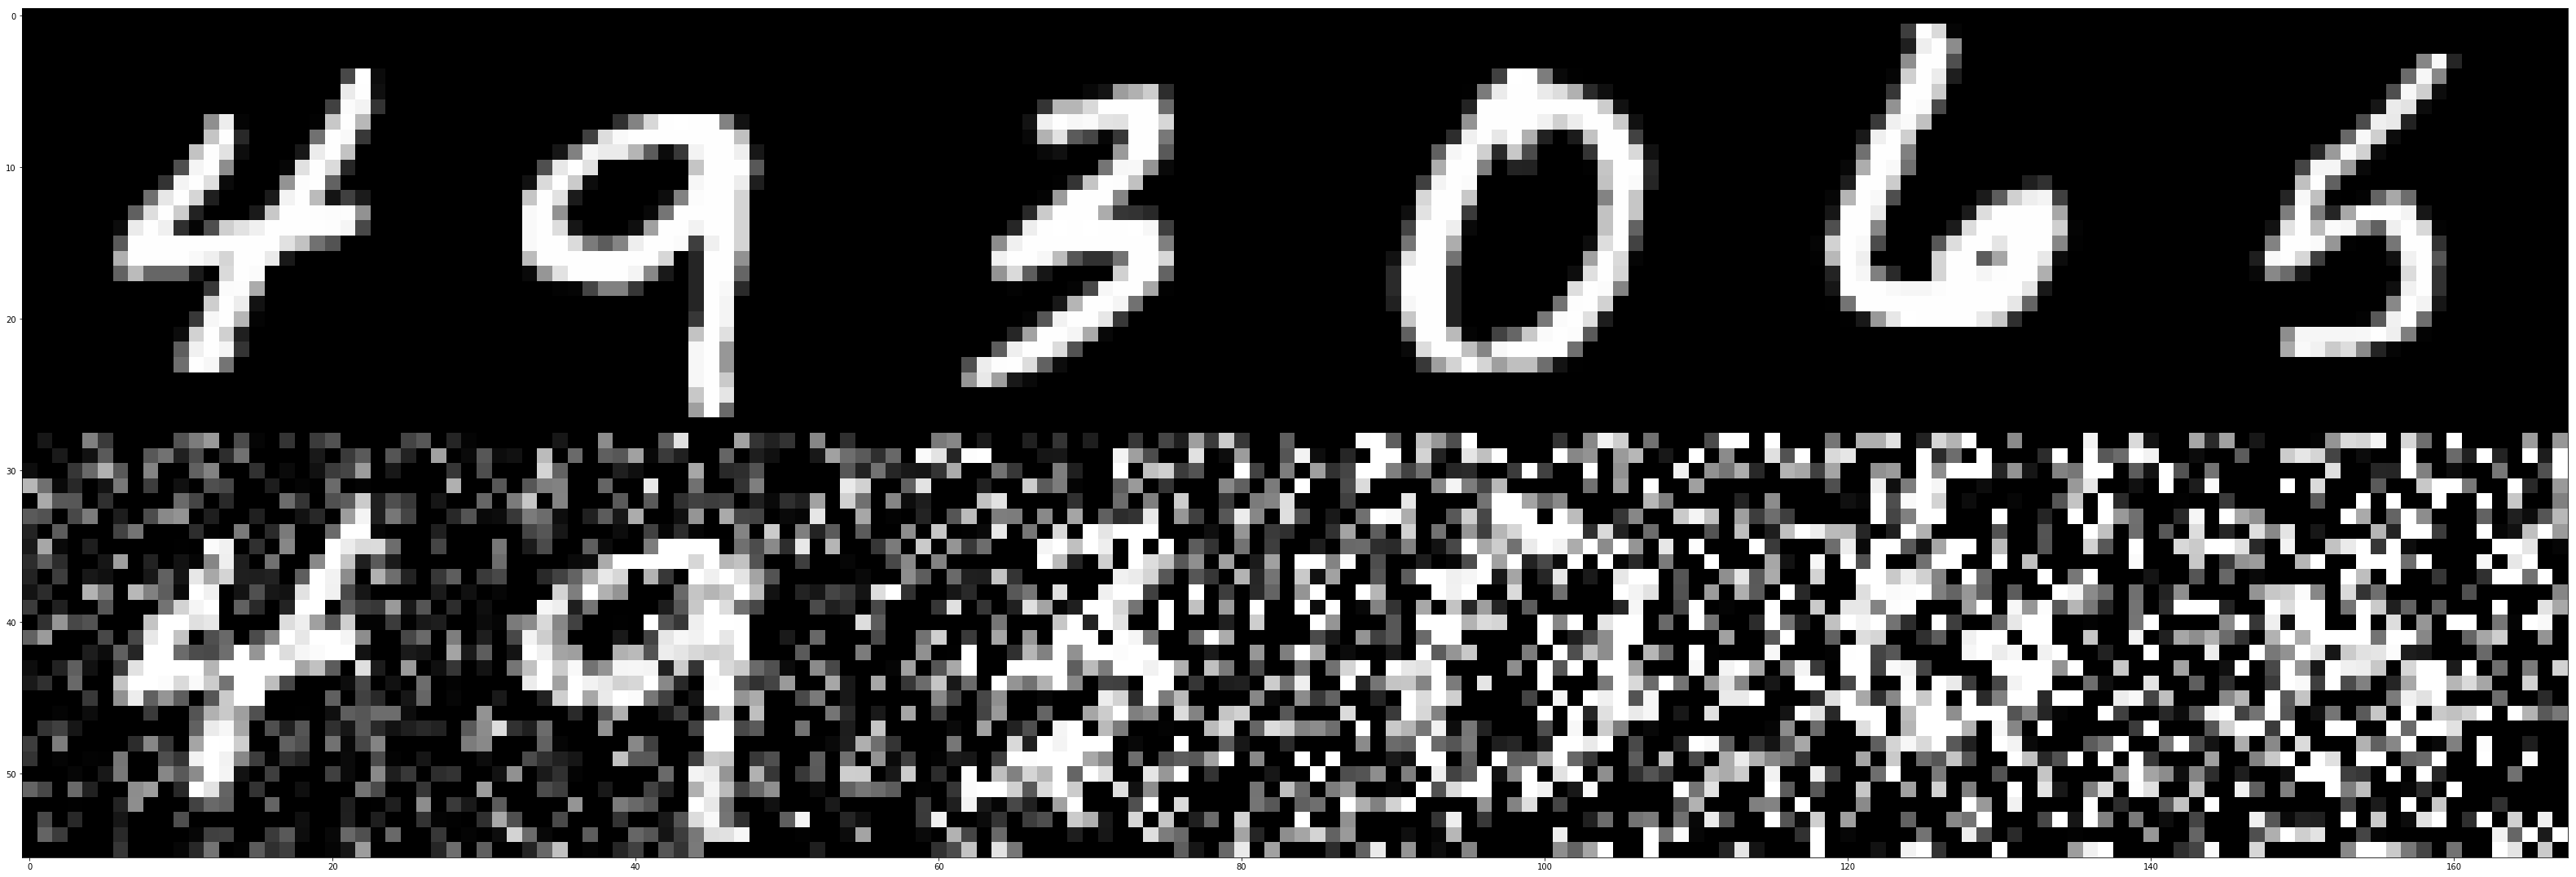

In [8]:
n_images = 6
figure = np.zeros((28*2 , 28 * n_images))
# Display
showidx=np.random.randint(0,train_num,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
plt.figure(figsize=(28*2, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show() 

In [9]:
def create_encoder():
    noise = Input(shape=(28,28,1))
    x = Conv2D(32,(3, 3), padding='valid',activation='relu')(noise)
    x = Conv2D(32,(3, 3), padding='valid',activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    return Model(noise,x)

def create_decoder():
    feature = Input(shape=(2,2,64))
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(feature)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64,(3, 3), padding='same',activation='relu')(x)
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(32,(3, 3), padding='same',activation='relu')(x)
    x = Conv2DTranspose(32,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2DTranspose(1,(3, 3), padding='valid',activation='relu')(x)
    return Model(feature,x)

In [10]:
encoder=create_encoder()
decoder = create_decoder()
noise = Input(shape=(28,28,1))
f = encoder(noise)
x_out = decoder(f)
ae = Model(noise, x_out)
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2, 2, 64)          101920    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         175713    
Total params: 277,633
Trainable params: 277,633
Non-trainable params: 0
_________________________________________________________________


In [11]:
encoder.compile(optimizer='RMSprop', loss='binary_crossentropy')
decoder.compile(optimizer='RMSprop', loss='binary_crossentropy')
ae.compile(optimizer='RMSprop', loss='binary_crossentropy')

In [13]:
ae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.1176 - val_loss: 0.1267
Epoch 2/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.1166 - val_loss: 0.1140
Epoch 3/10
60000/60000 [==============================] - 5s 75us/step - loss: 0.1156 - val_loss: 0.1299
Epoch 4/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.1137 - val_loss: 0.1256
Epoch 5/10
60000/60000 [==============================] - 4s 74us/step - loss: 0.1137 - val_loss: 0.1164
Epoch 6/10
60000/60000 [==============================] - 4s 75us/step - loss: 0.1129 - val_loss: 0.1102
Epoch 7/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.1118 - val_loss: 0.1120
Epoch 8/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.1123 - val_loss: 0.1155
Epoch 9/10
60000/60000 [==============================] - 4s 75us/step - loss: 0.1114 - val_loss: 0.1186
Epoch

In [15]:
digit_size = 28
n=6
figure = np.zeros((digit_size * 3, digit_size * n))

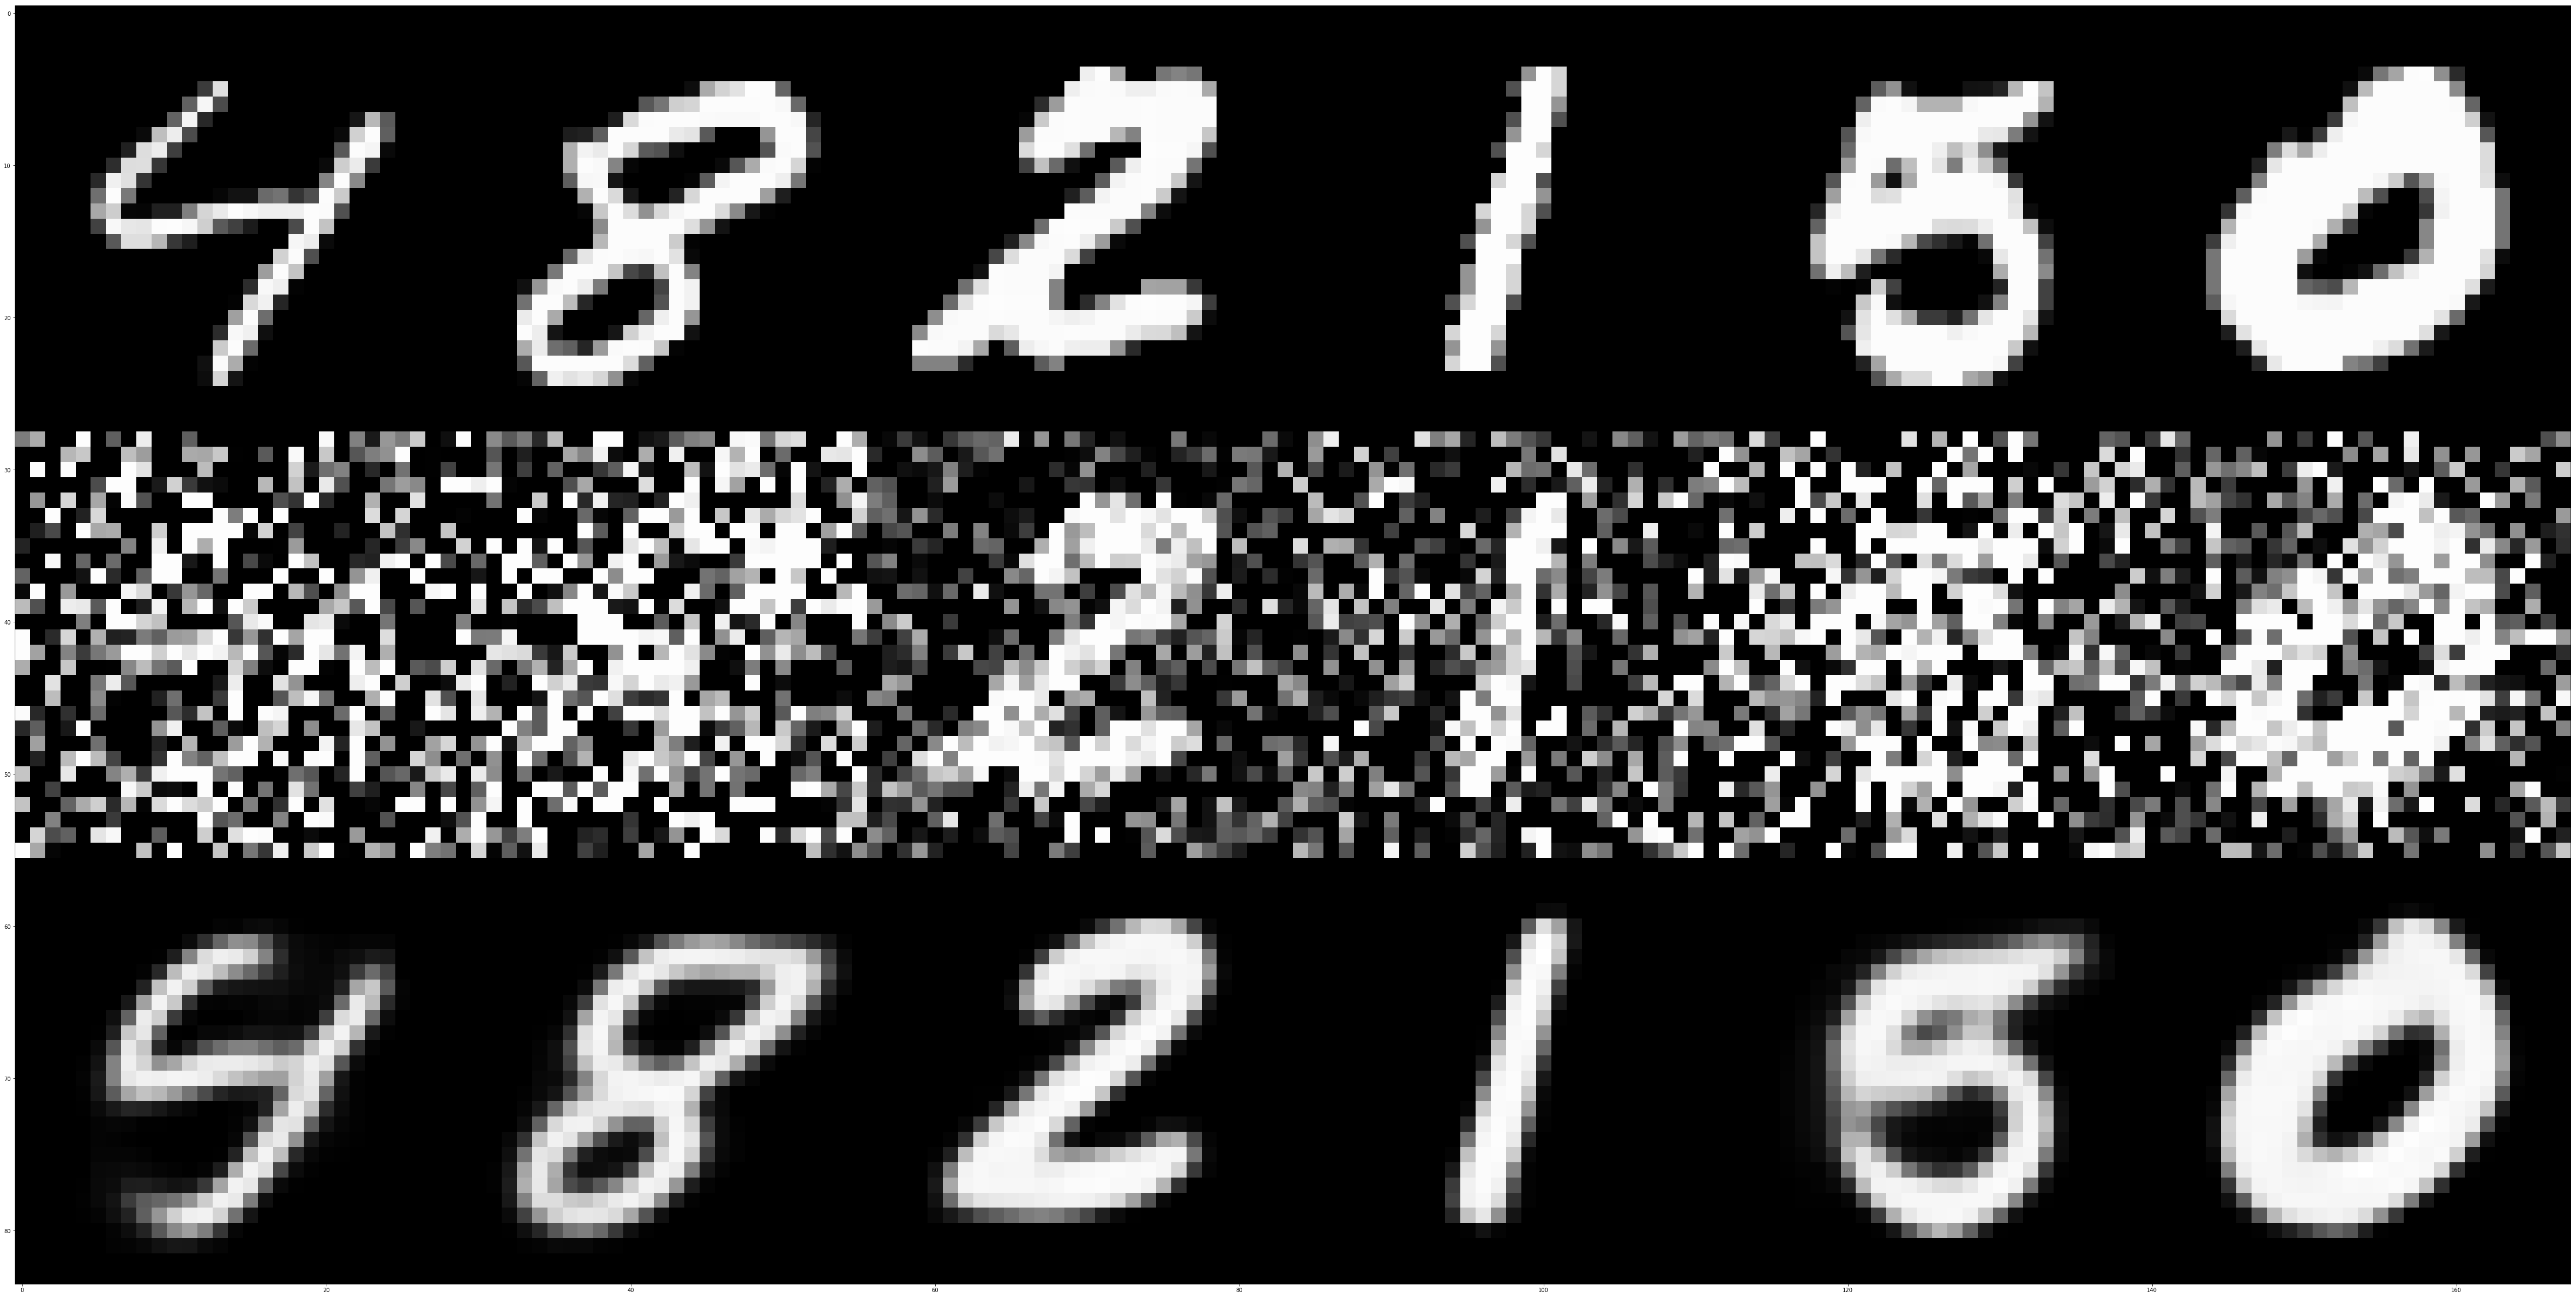

In [17]:
showidx=np.random.randint(0,test_num,n_images)
x_out=ae.predict(noise_test[showidx])
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_ae.png')
plt.show()